# **Install and Load Packages**

In [ ]:
!pip install causalml
!pip install scikit-plot

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
palette = {0: 'tab:blue',1:'tab:orange'}
import numpy as np
import seaborn as sns
import plotly.express as px

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, roc_auc_score, classification_report

import scikitplot as skplt

from causalml.dataset import make_uplift_classification
from causalml.inference.tree import UpliftRandomForestClassifier
import causalml.metrics as metrics

plt.rcParams["figure.figsize"] = (18, 9)
plt.rcParams["font.size"] = 25
sns.set()

# **Load Dataset**

In [ ]:
df = pd.read_csv("https://raw.githubusercontent.com/hadimaster65555/dataset_for_teaching/main/dataset/employee_turnover/turnover.csv", encoding = "ISO-8859-1")

Data Inspection

Check the first 5 rows

In [ ]:
df.sample(10)

,stag,event,gender,age,industry,profession,traffic,coach,head_gender,greywage,way,extraversion,independ,selfcontrol,anxiety,novator
921,16.065708,0,f,50.000000,Building,HR,rabrecNErab,no,m,white,bus,6.2,6.2,6.4,3.3,6.7
5,8.969199,1,f,42.000000,manufacture,HR,empjs,yes,m,white,bus,6.2,6.2,4.1,5.6,6.7
207,25.987680,1,f,23.000000,IT,HR,youjs,my head,f,white,bus,1.4,2.6,9.5,8.7,2.1
329,6.176591,1,f,38.000000,transport,HR,youjs,no,m,grey,bus,6.2,6.2,8.0,2.5,3.7
880,9.691992,0,f,35.000000,RealEstate,HR,rabrecNErab,no,m,white,car,7.8,3.4,5.7,4.0,6.0
453,23.983573,1,f,29.000000,Mining,HR,rabrecNErab,no,m,white,bus,4.6,5.5,5.7,4.8,7.5
711,49.872690,1,f,30.400333,State,Finanñe,referal,no,m,grey,bus,10.0,5.5,4.1,4.0,7.5
714,43.860370,0,f,29.000000,Retail,HR,youjs,no,f,white,car,8.6,6.2,4.9,4.8,9.0
415,36.599589,0,m,33.000000,Retail,HR,empjs,no,f,white,car,5.4,7.6,5.7,7.1,6.0
519,51.121150,0,f,28.000000,Retail,HR,youjs,no,f,white,car,5.4,5.5,6.4,2.5,4.4


**Data Inspection**

Check data structure

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1129 entries, 0 to 1128
Data columns (total 16 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   stag          1129 non-null   float64
 1   event         1129 non-null   int64  
 2   gender        1129 non-null   object 
 3   age           1129 non-null   float64
 4   industry      1129 non-null   object 
 5   profession    1129 non-null   object 
 6   traffic       1129 non-null   object 
 7   coach         1129 non-null   object 
 8   head_gender   1129 non-null   object 
 9   greywage      1129 non-null   object 
 10  way           1129 non-null   object 
 11  extraversion  1129 non-null   float64
 12  independ      1129 non-null   float64
 13  selfcontrol   1129 non-null   float64
 14  anxiety       1129 non-null   float64
 15  novator       1129 non-null   float64
dtypes: float64(7), int64(1), object(8)
memory usage: 141.2+ KB


In [ ]:
# check data dimension
df.shape

(1129, 16)

In [ ]:
# check null values inside dataset
df.isna().sum()

stag            0
event           0
gender          0
age             0
industry        0
profession      0
traffic         0
coach           0
head_gender     0
greywage        0
way             0
extraversion    0
independ        0
selfcontrol     0
anxiety         0
novator         0
dtype: int64

In [ ]:
# removes row with na values
df = df.dropna()

In [ ]:
# check dimension and null values inside dataset
print("Dimension of data: {}".format(df.shape))
print("Number of null values:")
df.isna().sum()

Dimension of data: (1129, 16)
Number of null values:


stag            0
event           0
gender          0
age             0
industry        0
profession      0
traffic         0
coach           0
head_gender     0
greywage        0
way             0
extraversion    0
independ        0
selfcontrol     0
anxiety         0
novator         0
dtype: int64

# Simple EDA

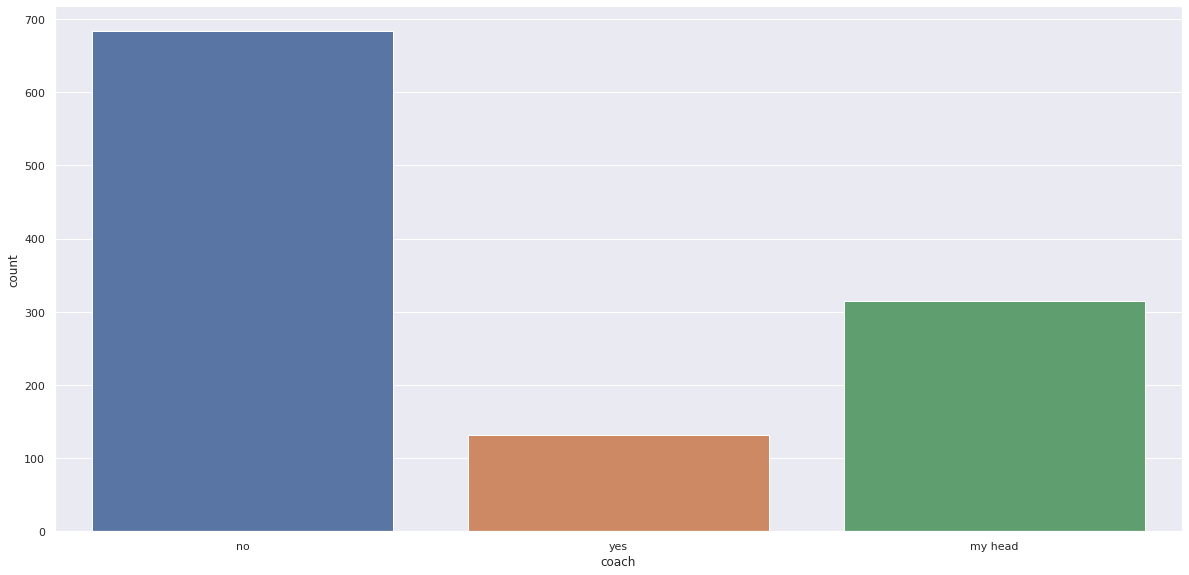

In [ ]:
# check variable treatment distribution
sns.countplot(data = df, x = 'coach');

Terlihat bahwa untuk distribusi tratment data yang tidak diberikan 'coach' dengan yang diberikan 'coach'  dan 'my head' memiliki perbedaan yang signifikan. Karena my head termasuk data kriteria yang diberikan pelatihan, olehkarena itu untuk data my_head dirubah menjadi YES karena pada kasus kali ini adalah tujuannya untuk menentukan seberapa loyal seorang karyawan terhadap treatment yang telah diberikan pelatihan.

In [ ]:
check_myhead = df[df['coach'] == 'my head']
check_myhead['coach']

12      my head
14      my head
26      my head
28      my head
29      my head
         ...   
1097    my head
1101    my head
1103    my head
1124    my head
1125    my head
Name: coach, Length: 314, dtype: object

In [ ]:
# Change ? with NO column collision

df.loc[df['coach'] == 'my head' , 'coach'] = 'yes'

In [ ]:
df['coach'].head()

0     no
1     no
2     no
3     no
4    yes
Name: coach, dtype: object

In [ ]:
df.sample(20)

,stag,event,gender,age,industry,profession,traffic,coach,head_gender,greywage,way,extraversion,independ,selfcontrol,anxiety,novator
305,23.983573,1,f,23.0,Agriculture,Consult,referal,yes,m,white,bus,4.6,6.9,7.2,2.5,2.9
164,4.533881,1,f,31.0,Retail,Sales,KA,no,f,grey,bus,5.4,5.5,7.2,4.8,1.3
1050,19.055441,0,f,26.0,IT,HR,youjs,yes,m,grey,bus,3.8,3.4,8.7,7.1,6.0
190,26.217659,1,f,36.0,etc,HR,empjs,no,m,white,foot,2.2,6.9,8.0,6.3,3.7
123,3.975359,1,f,29.0,Retail,etc,empjs,no,m,white,bus,6.2,6.2,5.7,6.3,2.9
453,23.983573,1,f,29.0,Mining,HR,rabrecNErab,no,m,white,bus,4.6,5.5,5.7,4.8,7.5
918,105.823409,0,f,32.0,IT,HR,referal,no,f,white,bus,4.6,7.6,4.1,4.8,6.0
80,59.203285,1,f,25.0,Banks,HR,recNErab,no,f,white,bus,4.6,4.1,8.7,5.6,2.1
131,49.379877,1,f,22.0,etc,Marketing,rabrecNErab,no,f,grey,car,5.4,6.9,6.4,4.0,4.4
1054,51.843943,0,f,34.0,IT,BusinessDevelopment,friends,yes,m,white,car,4.6,4.1,4.9,9.4,6.7


In [ ]:
# conversion label
#coach_label = np.array(df.coach == 'yes').astype(int)

In [ ]:
# Check replacement
df['coach'].head(11)

0      no
1      no
2      no
3      no
4     yes
5     yes
6     yes
7      no
8      no
9     yes
10     no
Name: coach, dtype: object

In [ ]:
# check jumlah data No dan yes dalam variable coach
df.coach.value_counts()

no     683
yes    446
Name: coach, dtype: int64

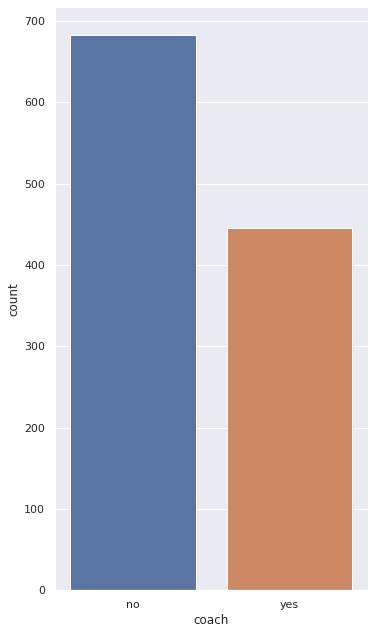

In [ ]:
sns.countplot(data = df, x = 'coach');

Terlihat pada hasil output visualisasi diatas bahwa banyak karyawan yang tidak diberikan pelatihan dari pada yan diberikan pelatihan

In [ ]:
# checking unique on qs_columns
qs_columns = ['coach']

for col in qs_columns:
  print('='*10)
  print(f'Columns: {col}')
  print(df[col].unique())

Columns: coach
['no' 'yes']


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1129 entries, 0 to 1128
Data columns (total 16 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   stag          1129 non-null   float64
 1   event         1129 non-null   int64  
 2   gender        1129 non-null   object 
 3   age           1129 non-null   float64
 4   industry      1129 non-null   object 
 5   profession    1129 non-null   object 
 6   traffic       1129 non-null   object 
 7   coach         1129 non-null   object 
 8   head_gender   1129 non-null   object 
 9   greywage      1129 non-null   object 
 10  way           1129 non-null   object 
 11  extraversion  1129 non-null   float64
 12  independ      1129 non-null   float64
 13  selfcontrol   1129 non-null   float64
 14  anxiety       1129 non-null   float64
 15  novator       1129 non-null   float64
dtypes: float64(7), int64(1), object(8)
memory usage: 182.2+ KB


In [ ]:
df.head(11)

In [ ]:
df['coach'] = df['coach'].astype(str)

In [ ]:
coach = df['coach'].value_counts()

In [ ]:
gender = df['gender'].value_counts()

fig = px.pie(gender,
             values = gender.values,
             names = gender.index,
             color_discrete_sequence=px.colors.sequential.RdBu)
fig.update_traces(textposition='inside', textinfo='percent+label',
                  marker = dict(line = dict(color = 'white', width = 1)))
fig.show()

Pada hasil output visualisasi diatas terlihat untuk gender didominasi perempuan yaitu sekitar 75,6% dan laki-laki sekitar 24,45

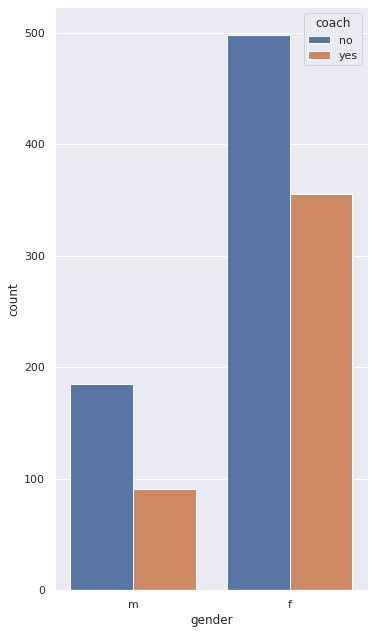

In [ ]:
 # count plot on two categorical variable
sns.countplot(x ='gender', hue = "coach", data = df)
 # Show the plot
plt.show()

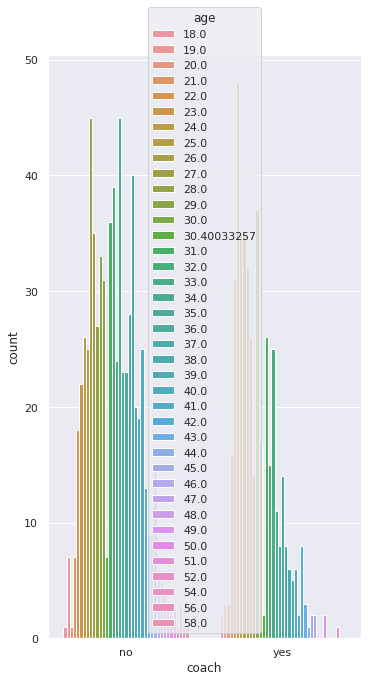

In [ ]:
 # count plot on two categorical variable
sns.countplot(x ='coach', hue = "age", data = df)
 # Show the plot
plt.show()

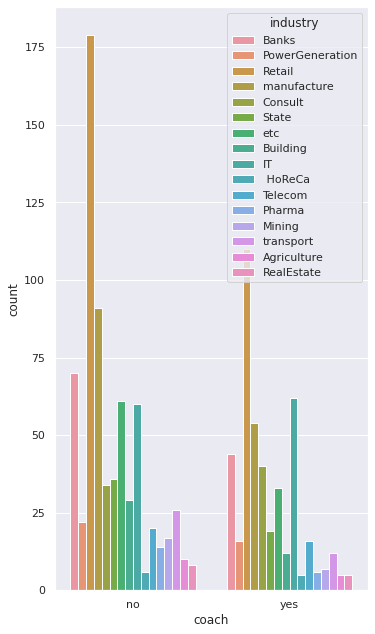

In [ ]:
 # count plot on two categorical variable
sns.countplot(x ='coach', hue = "industry", data = df)
 # Show the plot
plt.show()

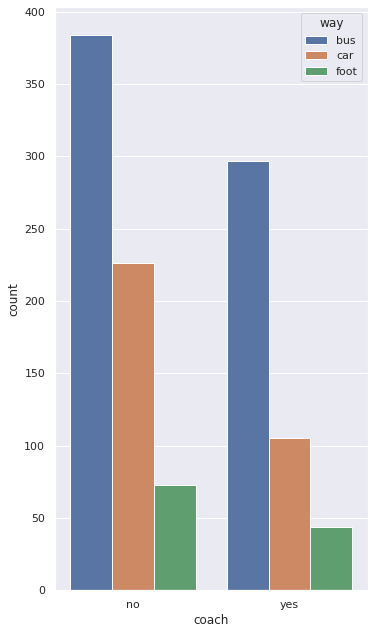

In [ ]:
 # count plot on two categorical variable
sns.countplot(x ='coach', hue = "way", data = df)
 # Show the plot
plt.show()

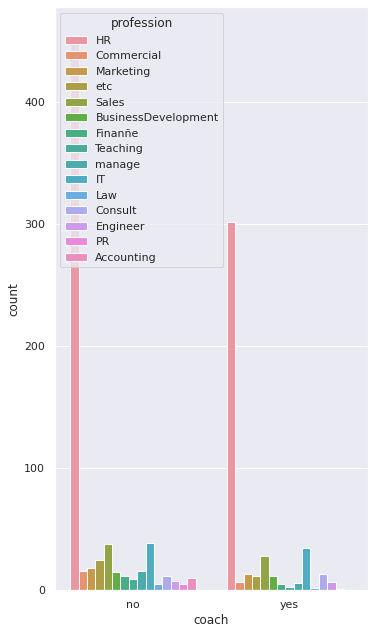

In [ ]:
 # count plot on two categorical variable
sns.countplot(x ='coach', hue = "profession", data = df)
 # Show the plot
plt.show()

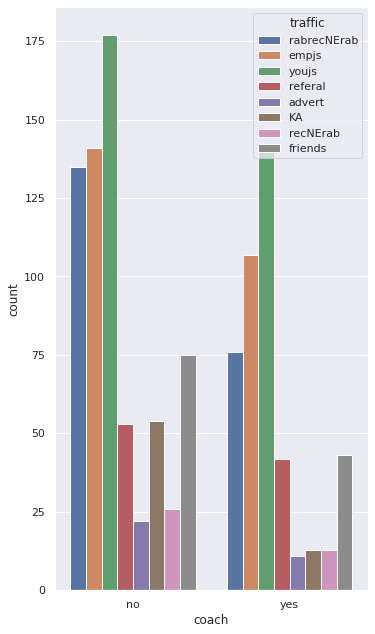

In [ ]:
 # count plot on two categorical variable
sns.countplot(x ='coach', hue = "traffic", data = df)
 # Show the plot
plt.show()

# **Train-Test Split Data**

In [ ]:
X_train, X_test = train_test_split(
    df.drop(['extraversion', 'independ', 'selfcontrol', 'anxiety', 'novator'], axis = 1), 
    test_size = 0.5, 
    random_state = 1000)

In [ ]:
# treatment label
treatment_label = np.array(df.coach == "yes").astype(int)
# conversion label
event_label = np.array(df.event == 1).astype(int)
# Exclude treatment and conversion label
data_for_model = df.drop(['coach', 'event', 'extraversion', 'independ', 'selfcontrol', 'anxiety', 'novator'], axis = 1)

# **Data Exploration**

In [ ]:
X_train.head()

,stag,event,gender,age,industry,profession,traffic,coach,head_gender,greywage,way
1052,29.700205,0,m,47.0,IT,Consult,rabrecNErab,no,m,white,bus
396,9.100616,1,f,26.0,State,HR,referal,no,m,white,car
670,55.950719,0,f,40.0,etc,HR,youjs,no,f,white,foot
521,15.112936,0,f,45.0,State,HR,rabrecNErab,no,f,white,bus
971,19.942505,1,f,23.0,manufacture,Commercial,youjs,yes,f,white,bus


In [ ]:
X_train.coach.value_counts()

no     338
yes    226
Name: coach, dtype: int64

Do one-hot encoding for each categorical variable

In [ ]:
X_train['way'].value_counts()

bus     351
car     154
foot     59
Name: way, dtype: int64

In [ ]:
X_train['greywage'].value_counts()

white    503
grey      61
Name: greywage, dtype: int64

In [ ]:
X_train['head_gender'].value_counts()

m    282
f    282
Name: head_gender, dtype: int64

In [ ]:
X_train['traffic'].value_counts()

youjs          157
empjs          127
rabrecNErab    108
friends         53
referal         47
KA              39
advert          18
recNErab        15
Name: traffic, dtype: int64

In [ ]:
X_train['profession'].value_counts()

HR                     377
IT                      37
Sales                   33
Marketing               18
etc                     15
Consult                 14
BusinessDevelopment     13
manage                  12
Commercial               8
Finanñe                  8
Engineer                 8
Accounting               8
PR                       5
Teaching                 4
Law                      4
Name: profession, dtype: int64

In [ ]:
X_train['industry'].value_counts()

Retail             139
manufacture         74
IT                  68
Banks               54
etc                 50
Consult             34
State               28
Building            21
Telecom             20
transport           20
PowerGeneration     17
Pharma              10
Agriculture          9
RealEstate           8
Mining               7
 HoReCa              5
Name: industry, dtype: int64

In [ ]:
# column to encome
categorical_columns = ['gender',	'industry', 'profession',	'traffic',	'head_gender', 'greywage', 'way']

# Encode categorical variables on X train data
dummies = pd.get_dummies(X_train[categorical_columns], drop_first=True)
X_train = pd.concat([X_train.drop(categorical_columns, axis=1), dummies], axis=1)

# Encode categorical variables on X test data
dummies = pd.get_dummies(X_test[categorical_columns], drop_first=True)
X_test = pd.concat([X_test.drop(categorical_columns, axis=1), dummies], axis=1)

Check stag by experiment group

In [ ]:
is_treat = X_train[X_train.coach == "yes"]
not_treat = X_train[X_train.coach != "yes"]

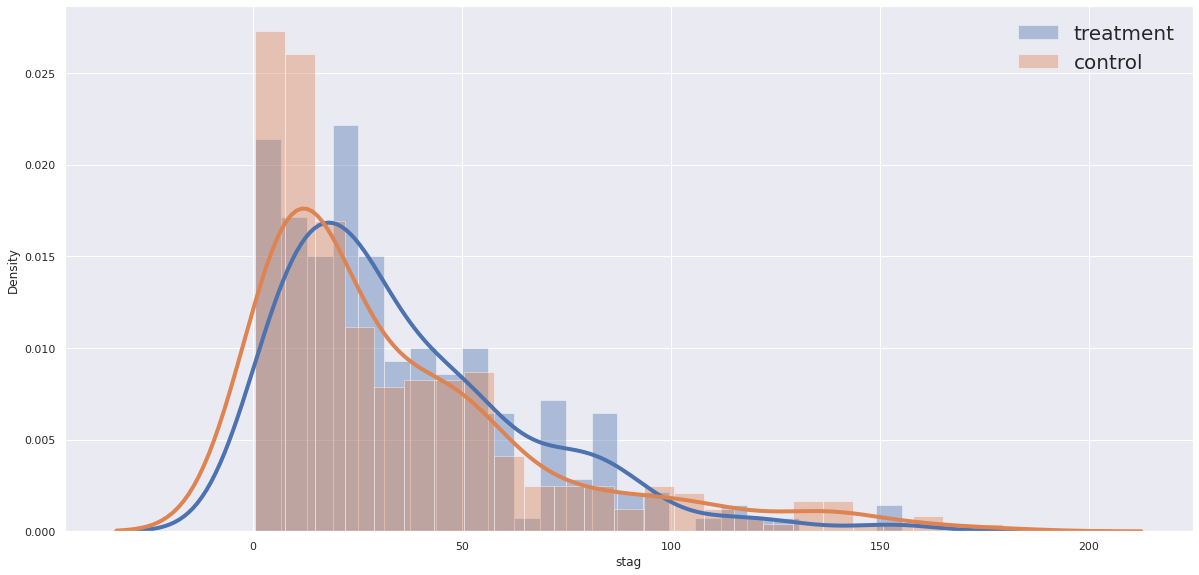

In [ ]:
bins = 25
sns.distplot(is_treat.stag, hist=True, kde=True, bins=bins, kde_kws={'linewidth': 4}, label='treatment')
sns.distplot(not_treat.stag, hist=True, kde=True, bins=bins, kde_kws={'linewidth': 4}, label='control')
plt.legend(frameon=False, loc=0, ncol=1, prop={'size': 20});

Check extraversion distribution by experiment group

# **Uplift-Tree (Uplift Random Forest)**

**Modeling**

In [ ]:
x_col = X_train.drop(['coach', 'event'], axis = 1).columns.tolist()
print(x_col)

['stag', 'age', 'gender_m', 'industry_Agriculture', 'industry_Banks', 'industry_Building', 'industry_Consult', 'industry_IT', 'industry_Mining', 'industry_Pharma', 'industry_PowerGeneration', 'industry_RealEstate', 'industry_Retail', 'industry_State', 'industry_Telecom', 'industry_etc', 'industry_manufacture', 'industry_transport', 'profession_BusinessDevelopment', 'profession_Commercial', 'profession_Consult', 'profession_Engineer', 'profession_Finanñe', 'profession_HR', 'profession_IT', 'profession_Law', 'profession_Marketing', 'profession_PR', 'profession_Sales', 'profession_Teaching', 'profession_etc', 'profession_manage', 'traffic_advert', 'traffic_empjs', 'traffic_friends', 'traffic_rabrecNErab', 'traffic_recNErab', 'traffic_referal', 'traffic_youjs', 'head_gender_m', 'greywage_white', 'way_car', 'way_foot']


Define uplift random forest classifier

In [ ]:
uplift_model = UpliftRandomForestClassifier(control_name='no', random_state=1000)

Fit model to data

In [ ]:
uplift_model.fit(
    X_train[x_col].values,
    treatment = X_train['coach'].values,
    y = X_train['event'].values
)

Do prediction with trained model

In [ ]:
y_pred = uplift_model.predict(X_test[x_col].values, full_output=True)

Check the first 5 rows

In [ ]:
y_pred.head()

,no,yes,recommended_treatment,delta_yes,max_delta
0,0.554651,0.475637,0,-0.079015,-0.079015
1,0.559173,0.488099,0,-0.071075,-0.071075
2,0.539457,0.507804,0,-0.031653,-0.031653
3,0.515015,0.585603,1,0.070588,0.070588
4,0.540795,0.575348,1,0.034553,0.034553


Check uplift distribution

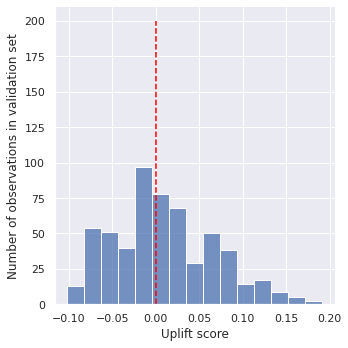

In [ ]:
sns.displot(data = y_pred, x = "delta_yes")
plt.vlines([0], 0, 200, linestyles = "dashed", colors = "red")
plt.xlabel('Uplift score')
plt.ylabel('Number of observations in validation set');

Again, create prediction with full_output = False

In [ ]:
y_pred = uplift_model.predict(X_test[x_col].values, full_output=False)

Save our uplift prediction to result variable

In [ ]:
result = pd.DataFrame(y_pred, columns=[uplift_model.classes_[1]])

In [ ]:
result.head()

,yes
0,-0.079015
1,-0.071075
2,-0.031653
3,0.070588
4,0.034553


In [ ]:
# If all deltas are negative, assing to control; otherwise assign to the treatment
# with the highest delta
best_treatment = np.where(
    (result < 0).all(axis=1),
    'no',
    result.idxmax(axis=1)
)

# Create indicator variables for whether a unit happened to have the
# recommended treatment or was in the control group
actual_is_best = np.where(X_test['coach'] == best_treatment, 1, 0)
actual_is_control = np.where(X_test['coach'] == 'no', 1, 0)

In [ ]:
synthetic = (actual_is_best == 1) | (actual_is_control == 1)

In [ ]:
np.unique(synthetic, return_counts = True)

(array([False,  True]), array([118, 447]))

Exclude user where synthetic = False

In [ ]:
synth = result[synthetic]

Calculate number of user who visit treated or not treated

In [ ]:
auuc_metrics = (synth.assign(
    is_treated = 1 - actual_is_control[synthetic],
    event = X_test.loc[synthetic, 'event'].values,
    uplift_tree = synth.max(axis=1)
).drop(columns=list(['yes'])))

Check the first 5 row

In [ ]:
auuc_metrics.head()

,is_treated,event,uplift_tree
0,0,0,-0.079015
1,0,0,-0.071075
2,0,1,-0.031653
3,0,0,0.070588
4,1,0,0.034553


Calculate treated group based who visit our platform, treated or not

In [ ]:
auuc_metrics

,is_treated,event,uplift_tree
0,0,0,-0.079015
1,0,0,-0.071075
2,0,1,-0.031653
3,0,0,0.070588
4,1,0,0.034553
...,...,...,...
560,0,0,0.057228
561,0,0,-0.039095
562,1,1,0.070750
563,1,1,0.021018


# **Model Evaluation**

Cumulative Gain Plot

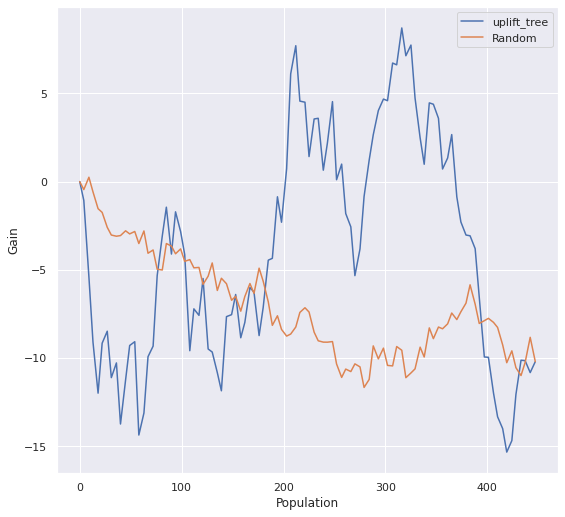

In [ ]:
metrics.plot_gain(auuc_metrics, outcome_col='event', treatment_col='is_treated')

AUUC and Qini Score

In [ ]:
metrics.auuc_score(auuc_metrics, outcome_col='event', treatment_col='is_treated')

uplift_tree   -0.367614
Random        -0.683531
dtype: float64

In [ ]:
metrics.qini_score(auuc_metrics, outcome_col='event', treatment_col='is_treated')

uplift_tree    0.289331
Random         0.000000
dtype: float64

# Quantile Metrics

If the model is working well, we should see a larger positive difference in the highest decile, decreasing to a small or negative difference in the lowest decile (i.e. treatment rate similar to control rate, or lower than control rate). In other words, as predicted uplift increases, the true uplift from control to treatment group should increase as well.

Create new dataframe object

In [ ]:
valid_w_score = X_test.copy()
valid_w_score['Uplift score'] = y_pred

 Check the first 5 rows

In [ ]:
valid_w_score.head()

,stag,event,age,coach,gender_m,industry_Agriculture,industry_Banks,industry_Building,industry_Consult,industry_IT,...,traffic_friends,traffic_rabrecNErab,traffic_recNErab,traffic_referal,traffic_youjs,head_gender_m,greywage_white,way_car,way_foot,Uplift score
301,27.236140,0,27.0,no,0,0,0,0,0,0,...,0,0,0,0,0,1,1,0,0,-0.079015
415,36.599589,0,33.0,no,1,0,0,0,0,0,...,0,0,0,0,0,0,1,1,0,-0.071075
154,79.868583,1,23.0,no,1,0,1,0,0,0,...,0,1,0,0,0,0,1,0,0,-0.031653
734,32.328542,0,49.0,no,1,0,0,0,0,0,...,1,0,0,0,0,1,0,1,0,0.070588
550,46.948665,0,22.0,yes,0,0,0,0,0,0,...,0,1,0,0,0,0,1,1,0,0.034553


In [ ]:
valid_w_score['coach'].value_counts()

no     345
yes    220
Name: coach, dtype: int64

Bin uplift score by using quantile

In [ ]:
score_quantiles, score_quantile_bins = pd.qcut(
    x = valid_w_score['Uplift score'],
    q = 10,
    retbins = True,
    duplicates = 'drop'
)

Calculate number of users for each bin

In [ ]:
score_quantiles.value_counts()

(-0.103, -0.0644]      67
(-0.0206, -0.00726]    65
(-0.0459, -0.0206]     58
(0.00701, 0.0159]      57
(0.0327, 0.0637]       57
(0.0637, 0.0849]       57
(0.0849, 0.192]        56
(0.0159, 0.0327]       55
(-0.0644, -0.0459]     47
(-0.00726, 0.00701]    46
Name: Uplift score, dtype: int64

Save quantile score as new column to valid_w_score

In [ ]:
valid_w_score['Quantile bin'] = score_quantiles

Check the first 5 rows

In [ ]:
valid_w_score[['coach', 'event', 'Uplift score', 'Quantile bin']].head(10)

,coach,event,Uplift score,Quantile bin
301,no,0,-0.079015,"(-0.103, -0.0644]"
415,no,0,-0.071075,"(-0.103, -0.0644]"
154,no,1,-0.031653,"(-0.0459, -0.0206]"
734,no,0,0.070588,"(0.0637, 0.0849]"
550,yes,0,0.034553,"(0.0327, 0.0637]"
569,yes,1,-0.101841,"(-0.103, -0.0644]"
308,no,0,0.020581,"(0.0159, 0.0327]"
509,yes,0,0.015569,"(0.00701, 0.0159]"
379,no,1,-0.011375,"(-0.0206, -0.00726]"
1014,yes,0,-0.002245,"(-0.00726, 0.00701]"


Calculate number of samples for each bins

In [ ]:
count_by_quantile_and_treatment = valid_w_score.groupby(['Quantile bin', 'coach'])['coach'].count().unstack(-1)

In [ ]:
count_by_quantile_and_treatment

coach,no,yes
Quantile bin,,
"(-0.103, -0.0644]",36,31
"(-0.0644, -0.0459]",25,22
"(-0.0459, -0.0206]",37,21
"(-0.0206, -0.00726]",38,27
"(-0.00726, 0.00701]",27,19
"(0.00701, 0.0159]",30,27
"(0.0159, 0.0327]",34,21
"(0.0327, 0.0637]",38,19
"(0.0637, 0.0849]",35,22


Visualize the impact of treatment

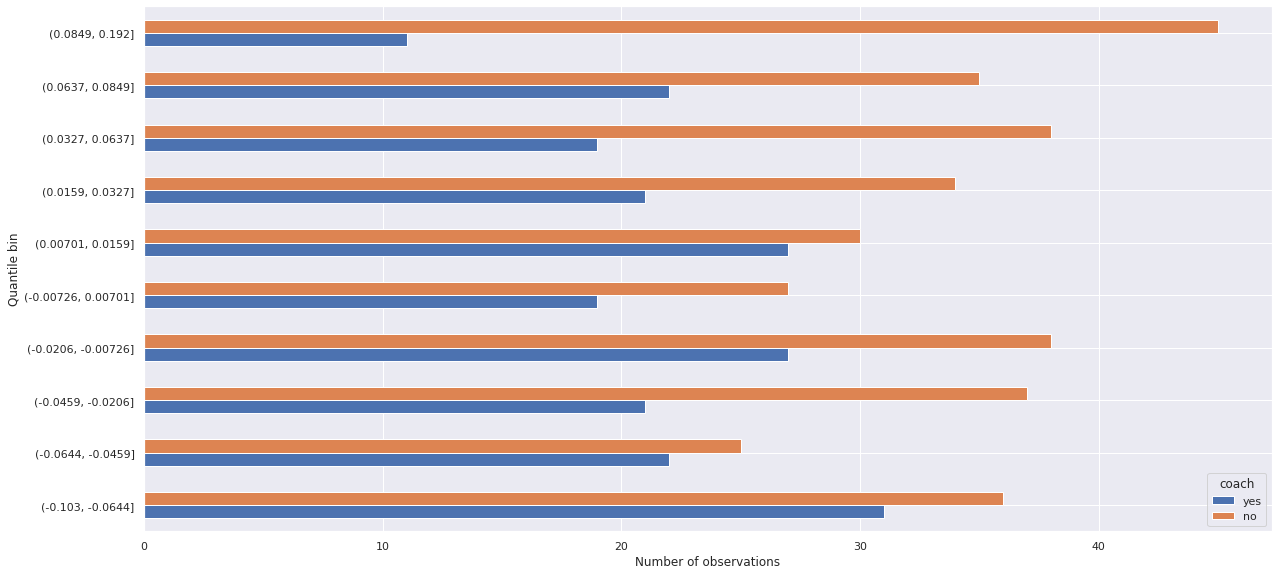

In [ ]:
count_by_quantile_and_treatment[['yes', 'no']].plot.barh()
plt.xlabel('Number of observations');

# **Uplift Quantile Chart**

In [ ]:
validation_treatment_mask = valid_w_score['coach'] == "no"

Get the conversion rates within uplift score quantiles for both groups

In [ ]:
treatment_by_quantile = valid_w_score[validation_treatment_mask]\
    .groupby('Quantile bin')['event'].mean()
control_by_quantile = valid_w_score[~validation_treatment_mask]\
    .groupby('Quantile bin')['event'].mean()

In [ ]:
true_uplift_by_quantile = treatment_by_quantile - control_by_quantile

Check the first 5 rows

In [ ]:
true_uplift_by_quantile.head(5)

Quantile bin
(-0.103, -0.0644]     -0.007168
(-0.0644, -0.0459]     0.441818
(-0.0459, -0.0206]     0.077220
(-0.0206, -0.00726]   -0.029240
(-0.00726, 0.00701]   -0.066277
Name: event, dtype: float64

Visualize uplift quantile chart

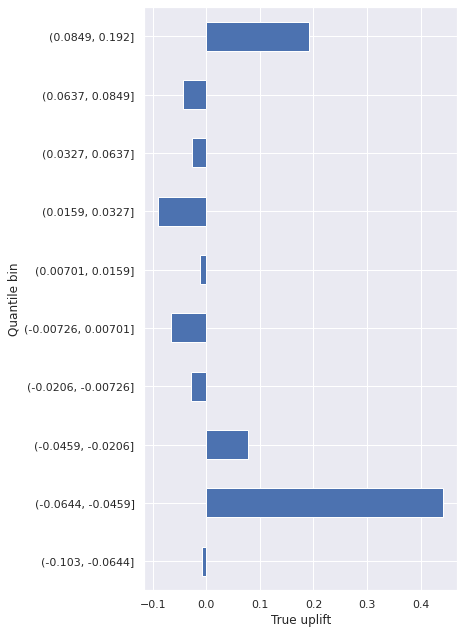

In [ ]:
plt.rcParams["figure.figsize"] = (5, 10)
true_uplift_by_quantile.plot.barh()
plt.xlabel('True uplift');

{intrepretation}

# **Model Interpretation**

In [ ]:
pd.DataFrame(
    {
        "Variable": x_col,
        "importance": uplift_model.feature_importances_
    }
).sort_values(by="importance", ascending = False)

,Variable,importance
41,way_car,0.223372
1,age,0.164706
0,stag,0.162723
39,head_gender_m,0.121416
38,traffic_youjs,0.105425
33,traffic_empjs,0.097467
2,gender_m,0.067849
23,profession_HR,0.042365
35,traffic_rabrecNErab,0.014676
37,traffic_referal,0.000000


penjelasan intrepretation

# **LINK GITHUB**

[Git Hub agung](https://)